In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import math

In [86]:
class KohonenNetwork:
    def __init__(self, M, N, input_dim, initial_sigma=1.0, sigma_decay=1.0, init_lr=0.1, decay_rate=100):
        # Inicjalizuje sieć z podanymi parametrami i przygotowuje wagi oraz mapę klastrów.
        self.M, self.N, self.input_dim = M, N, input_dim
        self.initial_sigma, self.sigma_decay = initial_sigma, sigma_decay
        self.init_lr, self.decay_rate = init_lr, decay_rate
        self.weights = np.random.rand(M, N, input_dim)
        self.bmu_cluster_map = np.zeros((M, N), dtype=int)

    def _gaussian(self, distance, sigma):
        # Oblicza wartość funkcji Gaussa dla danej odległości i parametru sigma.
        return np.exp(-distance**2 / (2 * sigma**2))

    def _find_bmu(self, sample):
        # Znajduje Best Matching Unit (BMU) dla danego wektora wejściowego.
        distances = np.linalg.norm(self.weights - sample, axis=2)
        return np.unravel_index(np.argmin(distances), self.weights.shape[:2])

    def _update_weights(self, sample, bmu, sigma, lr):
        # Aktualizuje wagi sieci w oparciu o BMU, sigma i współczynnik uczenia.
        bmu_x, bmu_y = bmu
        for i in range(self.M):
            for j in range(self.N):
                distance = np.linalg.norm(np.array([i, j]) - np.array([bmu_x, bmu_y]))
                self.weights[i, j] += lr * self._gaussian(distance, sigma) * (sample - self.weights[i, j])

    def _train_epoch(self, data, labels, sigma, lr, cluster_stats):
        # Przeprowadza jedną epokę treningu, aktualizując wagi dla wszystkich próbek.
        for sample, label in zip(data, labels):
            bmu = self._find_bmu(sample)
            cluster_stats.setdefault(bmu, {}).setdefault(label, 0)
            cluster_stats[bmu][label] += 1
            self._update_weights(sample, bmu, sigma, lr)

    def _assign_clusters(self, cluster_stats):
        # Przypisuje klastry do każdego z neuronów na podstawie statystyk klastrów.
        for bmu, stats in cluster_stats.items():
            self.bmu_cluster_map[bmu] = max(stats, key=stats.get)

    def train(self, data, labels, epochs):
        # Prowadzi proces uczenia sieci przez zadana liczbę epok.
        cluster_stats = {}
        for epoch in range(epochs):
            sigma = self.initial_sigma * np.exp(-epoch / self.decay_rate) * self.sigma_decay
            lr = self.init_lr * np.exp(-epoch / self.decay_rate)
            self._train_epoch(data, labels, sigma, lr, cluster_stats)
        self._assign_clusters(cluster_stats)

    def accuracy(self, data, labels):
        # Oblicza dokładność sieci na podstawie przypisania właściwych klastrów.
        if not data.size:
            return 0
        correct = sum(
            self.bmu_cluster_map[self._find_bmu(sample)] == actual_label 
            for sample, actual_label in zip(data, labels)
        )
        return (correct / len(data)) * 100

    def visualize_clusters(self, data):
        # Wizualizuje klastry na podstawie danych wejściowych.
        clusters = [self.bmu_cluster_map[self._find_bmu(sample)] for sample in data]
        self._plot_clusters(data, clusters)

    def _plot_clusters(self, data, clusters):
        # Tworzy wykresy klastrów dla danych 2D lub 3D.
        fig = plt.figure()
        if data.shape[1] == 3:
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=clusters, cmap='viridis', edgecolors='k', s=50)
            ax.set_title('Sklastrowane Dane 3D')
            ax.set_xlabel('Wymiar 1')
            ax.set_ylabel('Wymiar 2')
            ax.set_zlabel('Wymiar 3')
        else:
            scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', edgecolors='k', s=50)
            plt.title('Sklastrowane Dane 2D')
            plt.xlabel('Wymiar 1')
            plt.ylabel('Wymiar 2')
        plt.colorbar(scatter, label='Klaster')
        plt.show()

    def map_clusters(self, data, labels):
        # Mapuje klastry na podstawie danych wejściowych i etykiet.
        cluster_stats = {}
        for sample, label in zip(data, labels):
            bmu = self._find_bmu(sample)
            if bmu not in cluster_stats:
                cluster_stats[bmu] = []
            cluster_stats[bmu].append(label)
        self._visualize_cluster_data(cluster_stats)

    def _visualize_cluster_data(self, cluster_stats):
        # Wizualizuje dane klastrów na podstawie statystyk.
        cluster_matrix = np.zeros((self.M, self.N))
        coverage_matrix = np.zeros((self.M, self.N))
        for bmu, labels in cluster_stats.items():
            most_common = max(set(labels), key=labels.count)
            coverage = labels.count(most_common) / len(labels) * 100
            x, y = bmu
            cluster_matrix[x, y] = most_common
            coverage_matrix[x, y] = coverage
            print(f"BMU ({x}, {y}) reprezentuje głównie klaster {most_common} z pokryciem {coverage:.2f}%.")
        self._plot_cluster_data(cluster_matrix, coverage_matrix)

    def _plot_cluster_data(self, cluster_matrix, coverage_matrix):
        # Rysuje wykresy danych klastra.
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        cluster_display = axs[0].imshow(cluster_matrix, cmap='viridis', aspect='auto')
        axs[0].set_title('Dominujący Klaster na BMU')
        axs[0].set_xlabel('Współrzędna X neuronu')
        axs[0].set_ylabel('Współrzędna Y neuronu')
        fig.colorbar(cluster_display, ax=axs[0], orientation='vertical')
        coverage_display = axs[1].imshow(coverage_matrix, cmap='viridis', aspect='auto', vmin=0, vmax=100)
        axs[1].set_title('Pokrycie Dominującego Klastra na BMU')
        axs[1].set_xlabel('Współrzędna X neuronu')
        axs[1].set_ylabel('Współrzędna Y neuronu')
        fig.colorbar(coverage_display, ax=axs[1], orientation='vertical')
        plt.tight_layout()
        plt.show()

In [87]:
hexagon = pd.read_csv('../data/hexagon.csv').values
cube = pd.read_csv('../data/cube.csv').values

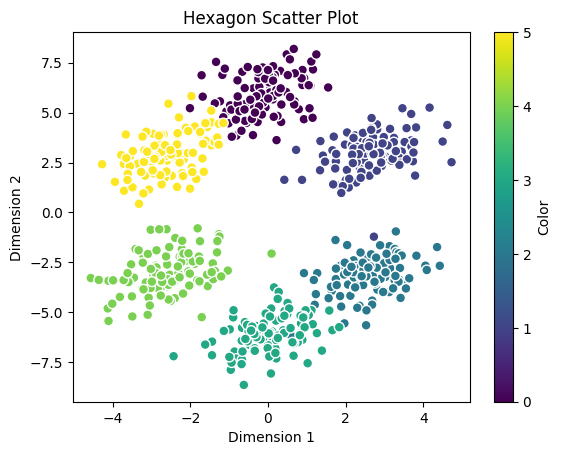

In [88]:
plt.scatter(hexagon[:, 0], hexagon[:, 1], c=hexagon[:, 2], cmap='viridis', edgecolors='w', s=50)
plt.title('Hexagon Scatter Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Color')
plt.show()


In [89]:
data_hex = pd.read_csv('../data/hexagon.csv').values[:, :2]
data_cube = pd.read_csv('../data/cube.csv').values[:, :3]

In [90]:
labels_hex = pd.read_csv('../data/hexagon.csv').values[:, -1]
labels_cube = pd.read_csv('../data/cube.csv').values[:, -1]

In [91]:
unique_labels = np.unique(labels_hex)
print(unique_labels)


[0. 1. 2. 3. 4. 5.]


In [92]:
network = KohonenNetwork(M=10, N=10, input_dim=2, initial_sigma=1.0, sigma_decay=0.1, init_lr=0.10, decay_rate=100)

In [93]:
network.train(data_hex, labels_hex, 10)

In [94]:
accuracy = network.accuracy(data_hex, labels_hex)
print(f"Cluster accuracy: {accuracy:.2f}%")

AttributeError: 'KohonenNetwork' object has no attribute '_find_bmu'

BMU (2, 0) reprezentuje głównie klaster 1.0 z pokryciem 90.91%.
BMU (3, 5) reprezentuje głównie klaster 0.0 z pokryciem 93.20%.
BMU (3, 3) reprezentuje głównie klaster 2.0 z pokryciem 98.77%.
BMU (6, 1) reprezentuje głównie klaster 1.0 z pokryciem 100.00%.
BMU (2, 1) reprezentuje głównie klaster 1.0 z pokryciem 100.00%.
BMU (8, 8) reprezentuje głównie klaster 4.0 z pokryciem 100.00%.
BMU (4, 5) reprezentuje głównie klaster 4.0 z pokryciem 100.00%.
BMU (7, 4) reprezentuje głównie klaster 3.0 z pokryciem 97.44%.
BMU (6, 6) reprezentuje głównie klaster 3.0 z pokryciem 57.14%.
BMU (5, 1) reprezentuje głównie klaster 5.0 z pokryciem 98.94%.
BMU (8, 6) reprezentuje głównie klaster 2.0 z pokryciem 100.00%.
BMU (7, 8) reprezentuje głównie klaster 1.0 z pokryciem 100.00%.
BMU (1, 1) reprezentuje głównie klaster 1.0 z pokryciem 100.00%.
BMU (4, 0) reprezentuje głównie klaster 4.0 z pokryciem 100.00%.
BMU (8, 7) reprezentuje głównie klaster 1.0 z pokryciem 100.00%.


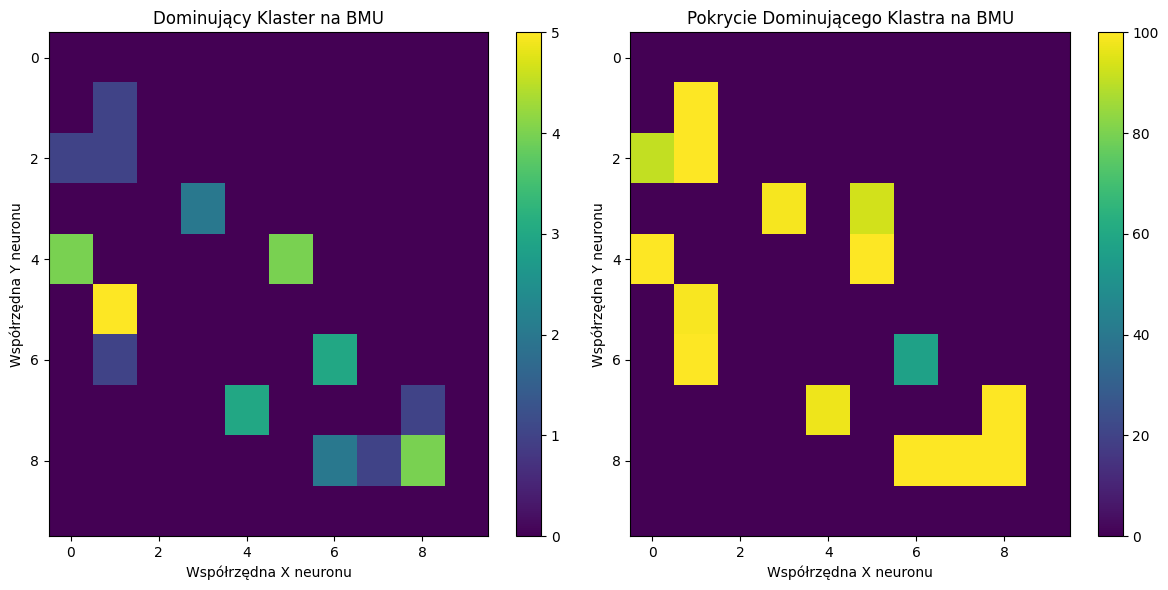

In [83]:
network.map_clusters(data_hex, labels_hex)

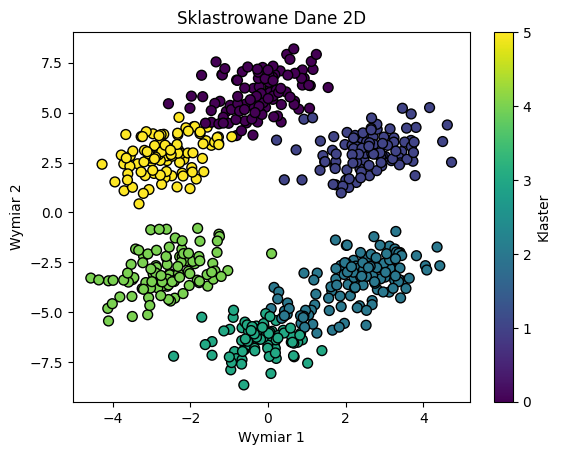

In [84]:
network.visualize_clusters(data_hex)

In [55]:
network2 = KohonenNetwork(M=3, N=2, input_dim=2, initial_sigma=1.0, sigma_decay=0.1, init_lr=3, decay_rate=100)


In [56]:
network2.train(data_hex, labels_hex, 10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/linalg/linalg.py:2582: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_45488/837686647.py:25: RuntimeWarning: overflow encountered in multiply
  self.weights[i, j] += lr * self._gaussian(distance, sigma) * (sample - self.weights[i, j])
/var/folders/ry/kcmcwh_95_jgg3sg1zp_pp5m0000gn/T/ipykernel_45488/837686647.py:25: RuntimeWarning: invalid value encountered in add
  self.weights[i, j] += lr * self._gaussian(distance, sigma) * (sample - self.weights[i, j])


In [57]:
accuracy2 = network2.accuracy(data_hex, labels_hex)
print(f"Cluster accuracy: {accuracy2:.2f}%")

Cluster accuracy: 16.67%


BMU (0, 0) reprezentuje głównie klaster 0.0 z pokryciem 16.67%.


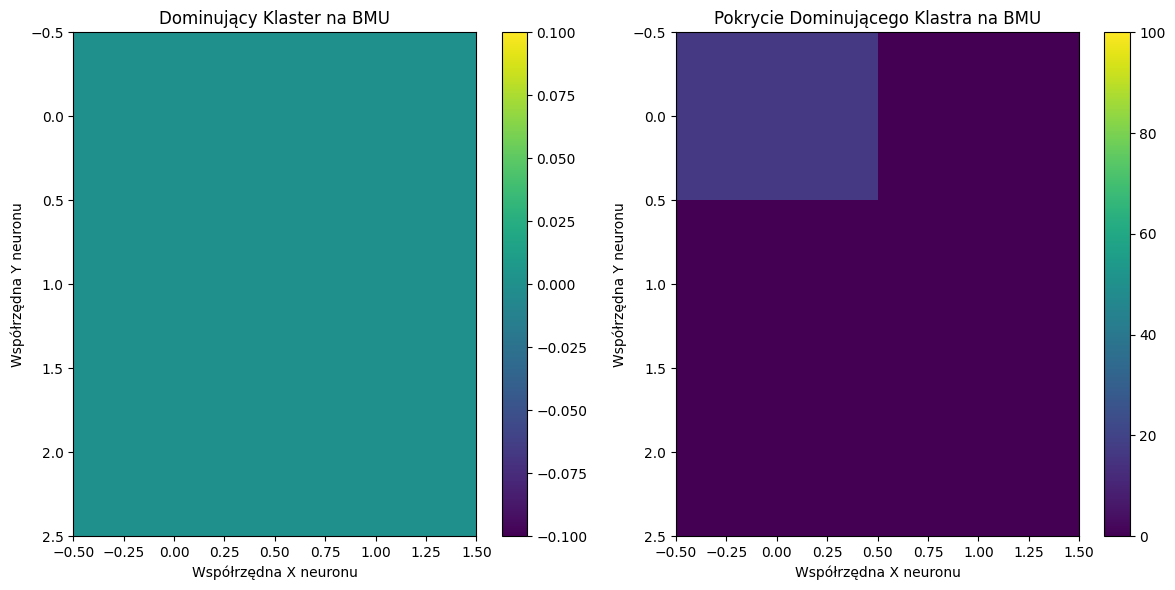

In [58]:
network2.map_clusters(data_hex, labels_hex)

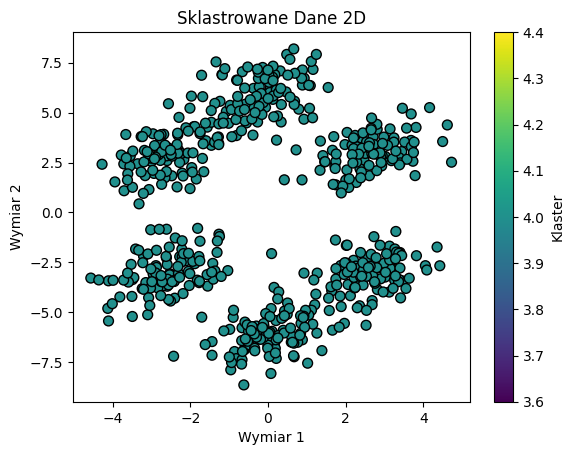

In [59]:
network2.visualize_clusters(data_hex)